In [1]:
%load_ext autoreload
%autoreload 2

# Data

In [2]:
import numpy as np
import tensorflow as tf

from time import time
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

In [3]:
UNK_token = 0
SOS_token = 1
EOS_token = 2

In [4]:
with open('./nmt_data/vocab.en', 'r') as f, open('./nmt_data/vocab.vi', 'r') as g:
    src_vocab = [x[:-1] for x in f.readlines()]
    tgt_vocab = [x[:-1] for x in g.readlines()]
    
def list_to_dict(vocab_list):
    ret = {}
    for i in range(len(vocab_list)):
        ret[i] = vocab_list[i]
    
    return ret

src_vocab, tgt_vocab = list_to_dict(src_vocab), list_to_dict(tgt_vocab)
src_vocab_inv, tgt_vocab_inv = {v: k for k, v in src_vocab.items()}, {v: k for k, v in tgt_vocab.items()}


def word2idx(vocab_inv, word):
    try:
        ret = vocab_inv[word]
    except:
        ret = UNK_token
    return ret

def idx2word(vocab, idx):
    return vocab[idx]

word2idx(src_vocab_inv, 'armpits'), idx2word(src_vocab, 17156)

In [5]:
with open('./nmt_data/train.en', 'r') as f:
    ss_L = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
    
with open('./nmt_data/mono.en', 'r') as f:
    ss_U = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
    
l = len(ss_L) #last index of labeled samples
u = l + len(ss_U) #last index of all samples

print(ss_L[0], [idx2word(src_vocab, x) for x in ss_L[0]])
print(ss_U[0], [idx2word(src_vocab, x) for x in ss_U[0]])

In [6]:
sources = ss_L
sources0 = np.array(ss_L)
sources.extend(ss_U)
sources = np.array(sources)

with open('./nmt_data/train.vi', 'r') as f:
    targets = [[word2idx(tgt_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]

targets = np.array(targets)

def label(i):
    if 0 <= i < l:
        return targets[i]

targets[0], [idx2word(tgt_vocab, x) for x in targets[0]]

# Batch

In [7]:
import networkx as nx
from embeddings_graph import EmbeddingsGraph

In [8]:
batch_size = 128
max_time = 50
time_major = True

graph = EmbeddingsGraph().graph

source_sequence_lengths: src_seq_l,
target_sequence_lengths:tgt_seq_l,
    
in_u1 = tf.placeholder(tf.int32, [None, max_time], name="in_u1")
in_v1 = tf.placeholder(tf.int32, [None, max_time], name="in_v1")
in_u2 = tf.placeholder(tf.int32, [None, max_time], name="in_u2")
in_v2 = tf.placeholder(tf.int32, [None, max_time], name="in_v2")
in_u3 = tf.placeholder(tf.int32, [None, max_time], name="in_u3")
in_v3 = tf.placeholder(tf.int32, [None, max_time], name="in_v3")

len_in_u1 = tf.placeholder(tf.int32, (), name="in_u1")
len_in_v1 = tf.placeholder(tf.int32, (), name="in_u1")
len_in_u2 = tf.placeholder(tf.int32, (), name="in_u1")
len_in_v2 = tf.placeholder(tf.int32, (), name="in_u1")
len_in_u3 = tf.placeholder(tf.int32, (), name="in_u1")
len_in_v3 = tf.placeholder(tf.int32, (), name="in_u1")

out_u1 = tf.placeholder(tf.int32, [None, max_time], name="out_u1")
out_v1 = tf.placeholder(tf.int32, [None, max_time], name="out_v1")
out_u2 = tf.placeholder(tf.int32, [None, max_time], name="out_u2")

len_out_u1
...


weights_ll = tf.placeholder(tf.float32, [None], name="wll")
weights_lu = tf.placeholder(tf.float32, [None], name="wlu")
weights_uu = tf.placeholder(tf.float32, [None], name="wuu")

cu1 = tf.placeholder(tf.float32, [None], name="CuLL")
cv1 = tf.placeholder(tf.float32, [None], name="CvLL")
cu2 = tf.placeholder(tf.float32, [None], name="CuLU")           

In [9]:
class Dummy(object):
    pass


def batch_iter(batch_size, sources, targets, ending=False):
    """
        Generates a batch iterator for the dataset.
    """

    data_size = len(sources)

    rand_inds = np.random.permutation(np.arange(data_size))

    num_batches = int(data_size / batch_size)

    if data_size % batch_size > 0:
        num_batches = int(data_size / batch_size) + 1

    batch_num = 0
    end_flag = False
    while True:
        start_index = batch_num * batch_size
        end_index = (batch_num + 1) * batch_size
        
        if end_index > data_size:
            if ending:
                end_flag = True
            else: 
                print('rebatching...')
                batch_num = 0
                rand_inds = np.random.permutation(rand_inds)
                start_index = 0
                end_index = batch_size
        
        
        srcs = sources[rand_inds[start_index:end_index]]
        tgts = targets[rand_inds[start_index:end_index]]
        source_sequence_lengths = np.array([np.min([len(x)+1, max_time]) for x in srcs])
        target_sequence_lengths = np.array([np.min([len(x)+1, max_time]) for x in tgts])
        
        srcs = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in srcs])
        tgts = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in tgts])
        
        srcs = srcs.T
        tgts = tgts.T
        
        params = Dummy()
        params.source_sequence_lengths = source_sequence_lengths
        params.target_sequence_lengths = target_sequence_lengths
        params.sources = srcs
        params.targets = tgts
        
        yield params
        
        if end_flag:
            return
        
        batch_num += 1
        
def next_batch(h_edges, start, finish):
    """
    Helper function for the iterator, note that the neural graph machines,
    due to its unique loss function, requires carefully crafted inputs

    Refer to the Neural Graph Machines paper, section 3 and 3.3 for more details
    """
    edges_ll = list()
    edges_lu = list()
    edges_uu = list()
    weights_ll = list()
    weights_lu = list()
    weights_uu = list()
    batch_edges = h_edges[start:finish]
    batch_edges = np.asarray(batch_edges)

    for i, j in batch_edges[:]:
        if (0 <= i < l) and (0 <= j < l):
            edges_ll.append((i, j))
            weights_ll.append(graph.get_edge_data(i,j)['weight'])
        elif (0 <= i < l) and (l <= j < u):
            edges_lu.append((i, j))
            weights_lu.append(graph.get_edge_data(i,j)['weight'])
        else:
            edges_uu.append((i, j))
            weights_uu.append(graph.get_edge_data(i,j)['weight'])
    
    if len(edges_ll)==0 or len(edges_lu)==0 or len(edges_uu)==0:
        print("No matched data. Reset the batch")
        np.random.shuffle(h_edges[start:])
        return next_batch(h_edges,start,finish)
        

    u_ll = [e[0] for e in edges_ll]

    # number of incident edges for nodes u
    c_ull = [1 / len(graph.edges(n)) for n in u_ll]
    v_ll = [e[1] for e in edges_ll]
    c_vll = [1 / len(graph.edges(n)) for n in v_ll]
    nodes_ll_u = sources[u_ll]
    
    labels_ll_u = np.empty(len(u_ll), dtype=np.object)
    labels_ll_u[:] = [label(n) for n in u_ll]
    
    nodes_ll_v = sources[v_ll]

    labels_ll_v = np.empty(len(v_ll), dtype=np.object)
    labels_ll_v[:] = [label(n) for n in v_ll]
    
    u_lu = [e[0] for e in edges_lu]
    c_ulu = [1 / len(graph.edges(n)) for n in u_lu]
    nodes_lu_u = sources[u_lu]
    nodes_lu_v = sources[[e[1] for e in edges_lu]]

    labels_lu = np.empty(len(u_lu), dtype=np.object)
    labels_lu[:] = [label(n) for n in u_lu]
    
    nodes_uu_u = sources[[e[0] for e in edges_uu]]
    nodes_uu_v = sources[[e[1] for e in edges_uu]]
    
    len_in_u1 = [np.min([len(x)+1, max_time]) for x in nodes_ll_u]
    len_in_v1 = [np.min([len(x)+1, max_time]) for x in nodes_ll_v]
    len_in_u2 = [np.min([len(x)+1, max_time]) for x in nodes_lu_u]
    len_in_v2 = [np.min([len(x)+1, max_time]) for x in nodes_lu_v]
    len_in_u3 = [np.min([len(x)+1, max_time]) for x in nodes_uu_u]
    len_in_v3 = [np.min([len(x)+1, max_time]) for x in nodes_uu_v]
    len_out_u1 = [np.min([len(x)+1, max_time]) for x in labels_ll_u]
    len_out_v1 = [np.min([len(x)+1, max_time]) for x in labels_ll_v]
    len_out_u2 = [np.min([len(x)+1, max_time]) for x in labels_lu]
    
    nodes_ll_u = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in nodes_ll_u]).T
    nodes_ll_v = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in nodes_ll_v]).T
    nodes_lu_u = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in nodes_lu_u]).T
    nodes_lu_v = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in nodes_lu_v]).T
    nodes_uu_u = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in nodes_uu_u]).T
    nodes_uu_v = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in nodes_uu_v]).T
    labels_ll_u = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in labels_ll_u]).T
    labels_ll_v = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in labels_ll_v]).T
    labels_lu = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in labels_lu]).T
        
    params = Dummy()
    params.in_u1 = nodes_ll_u
    params.in_v1 = nodes_ll_v
    params.out_u1 = labels_ll_u
    params.out_v1 = labels_ll_v
    params.in_u3 = nodes_uu_u
    params.in_v3 = nodes_uu_v
    params.in_u2 = nodes_lu_u
    params.in_v2 = nodes_lu_v
    params.out_u2 = labels_lu
    params.weights_ll = weights_ll
    params.weights_lu = weights_lu
    params.weights_uu = weights_uu
    params.cu1 = c_ull
    params.cv1 = c_vll
    params.cu2 = c_ulu
        
    params.len_in_u1 = len_in_u1
    params.len_in_v1 = len_in_v1
    params.len_in_u2 = len_in_u2
    params.len_in_v2 = len_in_v2
    params.len_in_u3 = len_in_u3
    params.len_in_v3 = len_in_v3
    params.len_out_u1 = len_out_u1
    params.len_out_v1 = len_out_v1
    params.len_out_u2 = len_out_u2
        
    return params


def batch_iter_ngm(batch_size):
    """
        Generates a batch iterator for the dataset.
    """

    data_size = len(graph.edges())

    edges = np.random.permutation(graph.edges())

    num_batches = int(data_size / batch_size)

    if data_size % batch_size > 0:
        num_batches = int(data_size / batch_size) + 1

    batch_num = 0
    while True:
        start_index = batch_num * batch_size
        end_index = (batch_num + 1) * batch_size
        
        if end_index > data_size:
            print("rebatching...")
            batch_num = 0
            edges = np.random.permutation(graph.edges())
            start_index = 0
            end_index = batch_size
            
        yield next_batch(edges,start_index,end_index)
        batch_num += 1

batch = batch_iter(batch_size)

params = next(batch)
print(params.in_u1[:,0])
print(params.len_in_u1[0])

# Model

In [10]:
from tensorflow.python.layers import core as layers_core
from tqdm import tqdm

In [11]:
# # Building the models

# ## The Embedding

# In[9]:

src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)
embedding_size = 512
num_units = embedding_size

In [12]:
def initialization():
    model = Dummy()
    model.encoder_inputs = tf.placeholder('int32', [max_time, None], name='encoder_inputs')
    model.targets = tf.placeholder('int32', [max_time, None], name='target')
    model.decoder_inputs = tf.concat([tf.fill([1, tf.shape(model.targets)[1]], SOS_token), model.targets[:-1,:]], 0)
    
    model.source_sequence_lengths = tf.placeholder('int32', [None], name='source_sequence_lengths')
    model.target_sequence_lengths = tf.placeholder('int32', [None], name='target_sequence_lengths')
    
    model.dropout = tf.placeholder('float32', [], name='dropout')
    model.learning_rate = tf.placeholder('float32', [], name='learning_rate')
    model.max_gradient_norm = tf.placeholder('float32', [], name='max_gradient_norm') # often set to a value like 5 or 1

    
    return model

model = initialization()

In [13]:
def embedding(model):
    with tf.variable_scope("embedding", dtype='float32') as scope:
        # Embedding
        embedding_encoder = tf.get_variable("embedding_encoder", [src_vocab_size, embedding_size])
        embedding_decoder = tf.get_variable("embedding_decoder", [tgt_vocab_size, embedding_size])
        # Look up embedding:
        #   encoder_inputs: [max_time, batch_size]
        #   encoder_emp_inp: [max_time, batch_size, embedding_size]
        encoder_emb_inp = tf.nn.embedding_lookup(embedding_encoder, model.encoder_inputs)
        decoder_emb_inp = tf.nn.embedding_lookup(embedding_decoder, model.decoder_inputs)
        
        model.embedding_encoder = embedding_encoder
        model.embedding_decoder = embedding_decoder
        model.encoder_emb_inp = encoder_emb_inp
        model.decoder_emb_inp = decoder_emb_inp
        
    return model

model = embedding(model)

In [14]:
# ## The Encoder
def encoder(model):
    with tf.variable_scope("encoder", dtype='float32') as scope:
        # Build RNN cell
        # Construct forward and backward cells
        forward_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
        forward_cell = tf.contrib.rnn.DropoutWrapper(cell=forward_cell, input_keep_prob=(1.0 - model.dropout))
        backward_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
        backward_cell = tf.contrib.rnn.DropoutWrapper(cell=backward_cell, input_keep_prob=(1.0 - model.dropout))

        bi_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
            forward_cell, backward_cell, model.encoder_emb_inp, dtype='float32',
            sequence_length=model.source_sequence_lengths, time_major=True)
        bi_encoder_outputs = tf.concat(bi_outputs, -1)
        
        encoder_outputs = bi_encoder_outputs
        encoder_state = bi_encoder_state
        """
        # Stacking encoders
        encoder_cell = tf.contrib.rnn.BasicLSTMCell(num_units)

        # Run Dynamic RNN
        #   encoder_outpus: [max_time, batch_size, num_units]
        #   encoder_state: [batch_size, num_units]
        encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
            encoder_cell, bi_encoder_outputs, dtype='float32',
            sequence_length=model.source_sequence_lengths, time_major=True)
        """        
        model.encoder_outputs = encoder_outputs
        model.encoder_state = encoder_state
        
    return model

model = encoder(model)

In [15]:
# ## Decoder
def decoder(model):
    with tf.variable_scope("decoder", dtype='float32') as scope:
        """ Attention Mechanisms """
        # attention_states: [batch_size, max_time, num_units]
        attention_states = tf.transpose(model.encoder_outputs, [1, 0, 2])

        # Create an attention mechanism
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(
            num_units, attention_states, scale=True,
            memory_sequence_length=model.source_sequence_lengths)

        # Build RNN cell
        cell_list = []
        for i in range(2):
            cell = tf.contrib.rnn.BasicLSTMCell(num_units)
            cell = tf.contrib.rnn.DropoutWrapper(cell=cell, input_keep_prob=(1.0 - model.dropout))
            cell_list.append(cell)
        
        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

        decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
            decoder_cell, attention_mechanism,
            attention_layer_size=num_units, name="attention")

        decoder_initial_state = decoder_cell.zero_state(tf.shape(model.decoder_emb_inp)[1], 'float32').clone(cell_state=model.encoder_state)
        """"""
        # Helper
        helper = tf.contrib.seq2seq.TrainingHelper(
            model.decoder_emb_inp, model.target_sequence_lengths, time_major=True)
        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, decoder_initial_state)
        # Dynamic decoding
        outputs, final_context_state, _ = tf.contrib.seq2seq.dynamic_decode(
            decoder,
            output_time_major=True,
            swap_memory=True,
            scope=scope)

        #projection
        output_layer = layers_core.Dense(tgt_vocab_size, use_bias=False, name="output_projection")
        logits = output_layer(outputs.rnn_output)
        
    model.logits = logits
    model.decoder_cell = decoder_cell
    model.decoder_initial_state = decoder_initial_state
    model.output_layer = output_layer
    model.final_context_state = final_context_state
    
    return model

model = decoder(model)

In [16]:
# ## Loss & Gradient computation & optimization

def crossent_loss(model):
    curr_max_time = tf.shape(model.logits)[0]
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=model.targets[:curr_max_time,:], logits=model.logits)
    target_weights = tf.sequence_mask(model.target_sequence_lengths, curr_max_time, dtype=model.logits.dtype)

    # When time_major is True
    target_weights = tf.transpose(target_weights)

    loss = tf.reduce_sum(crossent * target_weights) / tf.to_float(tf.shape(model.decoder_emb_inp)[1])

    
    return loss

In [17]:
def create_model():
    model = initialization()
    model = embedding(model)
    model = encoder(model)
    model = decoder(model)
    
    return model

In [18]:
with tf.variable_scope(tf.get_variable_scope()) as scope:
    ngm = Dummy()
    ngm.model0 = create_model()
    scope.reuse_variables()
    
    ngm.model_u1 = create_model()
    ngm.model_v1 = create_model()
    ngm.model_u2 = create_model()
    ngm.model_v2 = create_model()
    ngm.model_u3 = create_model()
    ngm.model_v3 = create_model()
    
    ngm.alpha_ll = tf.constant(1., dtype=np.float32, name="alpha_ll")
    ngm.alpha_lu = tf.constant(1., dtype=np.float32, name="alpha_lu")
    ngm.alpha_uu = tf.constant(.5, dtype=np.float32, name="alpha_uu")

    ngm.weights_ll = tf.placeholder(tf.float32, [None], name="weights_ll")
    ngm.weights_lu = tf.placeholder(tf.float32, [None], name="weights_lu")
    ngm.weights_uu = tf.placeholder(tf.float32, [None], name="weights_uu")

    ngm.cu_ll = tf.placeholder(tf.float32, [None], name="cu_ll")
    ngm.cv_ll = tf.placeholder(tf.float32, [None], name="cv_ll")
    ngm.cu_lu = tf.placeholder(tf.float32, [None], name="cu_lu")      

def vanilla_loss(model):
    curr_max_time = tf.shape(model.logits)[0]
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=model.targets[:curr_max_time,:], logits=model.logits)
    target_weights = tf.sequence_mask(model.target_sequence_lengths, curr_max_time, dtype=model.logits.dtype)

    # When time_major is True
    target_weights = tf.transpose(target_weights)

    loss = tf.reduce_sum(crossent * target_weights, 0)
    return loss

def distance_loss(model1, model2):
    scores_u = tf.concat((model1.final_context_state.cell_state[0].c, model1.final_context_state.cell_state[1].c), 1)
    scores_v = tf.concat((model2.final_context_state.cell_state[0].c, model2.final_context_state.cell_state[1].c), 1)
    
    beta = 0.97
    exp_mov_avg = tf.get_variable('exp_mov_avg', shape=[embedding_size*2], initializer=tf.constant_initializer(0.))
    exp_mov_var = tf.get_variable('exp_mov_var', shape=[embedding_size*2], initializer=tf.constant_initializer(0.))
    
    exp_mov_avg = exp_mov_avg.assign_sub((exp_mov_avg-tf.reduce_mean(tf.concat((scores_u, scores_v), 0), 0)) * (1 - beta)) 
    exp_mov_var = exp_mov_var.assign_sub((exp_mov_var-tf.square(exp_mov_avg)) * (1 - beta))
    
    #t = scores_u - scores_v
    #loss = tf.square(scores_u - scores_v)
    #loss = tf.reduce_sum(loss, 1)
    
    #loss = 1 - (tf.reduce_sum(tf.multiply(scores_u, scores_v), axis=1) / (tf.norm(scores_u, axis=1) * tf.norm(scores_v, axis=1)))
    
    loss = tf.pow(tf.reduce_sum(tf.square(scores_u-scores_v) / (exp_mov_var + 1e-4), 1), 0.5)
    return loss

In [19]:
def distance_loss(model1, model2):
    scores_u = tf.concat((model1.final_context_state.cell_state[0].c, model1.final_context_state.cell_state[1].c), 1)
    scores_v = tf.concat((model2.final_context_state.cell_state[0].c, model2.final_context_state.cell_state[1].c), 1)
    
    p = 1.0
    epsilon = 1e-6
    loss = tf.pow(tf.abs(scores_u - scores_v) + epsilon, p)
    loss = tf.pow(tf.reduce_sum(loss, 1), 1/p)
    return loss

In [20]:
def ngm_optimizer(ngm):

    l_vanilla = crossent_loss(ngm.model0)
    #l_vanilla = tf.reduce_mean(ngm.cu_ll * vanilla_loss(ngm.model_u1))
    #l_vanilla += tf.reduce_mean(ngm.cv_ll * vanilla_loss(ngm.model_v1))
    #l_vanilla += tf.reduce_mean(ngm.cu_lu * vanilla_loss(ngm.model_u2))

    with tf.variable_scope(tf.get_variable_scope()) as scope:
        l_dist1 = ngm.alpha_ll * ngm.weights_ll * distance_loss(ngm.model_u1, ngm.model_v1)
        scope.reuse_variables()
        l_dist2 = ngm.alpha_lu * ngm.weights_lu * distance_loss(ngm.model_u2, ngm.model_v2)
        l_dist3 = ngm.alpha_uu * ngm.weights_uu * distance_loss(ngm.model_u3, ngm.model_v3)
    ratio = 1
    l_dist = (tf.reduce_mean(l_dist1) + tf.reduce_mean(l_dist2) + tf.reduce_mean(l_dist3)) * ratio
    
    loss = l_vanilla + l_dist
    
    # Calculate and clip gradients
    parameters = tf.trainable_variables()
    gradients = tf.gradients(loss, parameters)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, ngm.model_u1.max_gradient_norm)

    # Optimization
    optimizer = tf.train.GradientDescentOptimizer(ngm.model_u1.learning_rate)
    update_step = optimizer.apply_gradients(zip(clipped_gradients, parameters))
    
    ngm.l_vanilla = l_vanilla
    ngm.l_dist = l_dist
    ngm.loss = loss
    ngm.update_step = update_step
    
    return ngm

In [21]:
ngm = ngm_optimizer(ngm)

In [22]:
# ## Running training

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

saver = tf.train.Saver()

saver = tf.train.Saver()
saver.restore(sess, './log/model.ckpt')

In [34]:
ls_vanilla, ls_dist = [], []

for i in range(1):
    params = next(batch)
    src_seq_l, tgt_seq_l, ss, ts = params.len_in_u1, params.len_out_u1, params.in_u1, params.out_u1

    feed_dict={model.learning_rate: 1.,
               model.dropout: .2,
               model.max_gradient_norm: 5,
               model.source_sequence_lengths: src_seq_l,
               model.target_sequence_lengths:tgt_seq_l,
               model.encoder_inputs: ss,
               model.targets: ts}


    _, l_val = sess.run([model.update_step, model.loss], feed_dict=feed_dict)
    ls.append(l_val)

In [35]:
batch0 = batch_iter(batch_size, sources0, targets)
batch = batch_iter_ngm(batch_size//2)

t_str = time()
for i in range(1000):
    params = next(batch)
    
    feed_dict={ngm.model_u1.learning_rate: 1.,
               ngm.model_u1.max_gradient_norm: 5,
               ngm.weights_ll: params.weights_ll,
               ngm.weights_lu: params.weights_lu,
               ngm.weights_uu: params.weights_uu,
               ngm.cu_ll: params.cu1,
               ngm.cv_ll: params.cv1,
               ngm.cu_lu: params.cu2,
               
               ngm.model_u1.dropout: .2,
               ngm.model_v1.dropout: .2,
               ngm.model_u2.dropout: .2,
               ngm.model_v2.dropout: .2,
               ngm.model_u3.dropout: .2,
               ngm.model_v3.dropout: .2,
               
               ngm.model_u1.source_sequence_lengths: params.len_in_u1,
               ngm.model_u1.target_sequence_lengths: params.len_out_u1,
               ngm.model_u1.encoder_inputs: params.in_u1,
               ngm.model_u1.targets: params.out_u1,
               
               ngm.model_v1.source_sequence_lengths: params.len_in_v1,
               ngm.model_v1.target_sequence_lengths: params.len_out_v1,
               ngm.model_v1.encoder_inputs: params.in_v1,
               ngm.model_v1.targets: params.out_v1,
               
               ngm.model_u2.source_sequence_lengths: params.len_in_u2,
               ngm.model_u2.target_sequence_lengths: params.len_out_u2,
               ngm.model_u2.encoder_inputs: params.in_u2,
               ngm.model_u2.targets: params.out_u2,
               
               ngm.model_v2.source_sequence_lengths: params.len_in_v2,
               ngm.model_v2.target_sequence_lengths: np.ones(params.in_v2.shape[1], 'float32') * EOS_token,
               ngm.model_v2.encoder_inputs: params.in_v2,
               ngm.model_v2.targets: np.ones((max_time, params.in_v2.shape[1]), 'int32') * EOS_token,

               ngm.model_u3.source_sequence_lengths: params.len_in_u3,
               ngm.model_u3.target_sequence_lengths: np.ones(params.in_u3.shape[1], 'float32') * EOS_token,
               ngm.model_u3.encoder_inputs: params.in_u3,
               ngm.model_u3.targets: np.ones((max_time, params.in_u3.shape[1]), 'int32') * EOS_token,
               
               ngm.model_v3.source_sequence_lengths: params.len_in_v3,
               ngm.model_v3.target_sequence_lengths: np.ones(params.in_v3.shape[1], 'float32') * EOS_token,
               ngm.model_v3.encoder_inputs: params.in_v3,
               ngm.model_v3.targets: np.ones((max_time, params.in_v3.shape[1]), 'int32') * EOS_token
               }


    _, l_v, l_d = sess.run([ngm.update_step, ngm.l_vanilla, ngm.l_dist], feed_dict=feed_dict)
    ls_vanilla.append(l_v)
    ls_dist.append(l_d)
    if (i % 10 == 0):
        view_str_idx = 0
        plt.figure(figsize=(20,10))
        plt.plot(np.arange(len(ls_vanilla)-view_str_idx)+view_str_idx, ls_vanilla[view_str_idx:], np.arange(len(ls_dist)-view_str_idx)+view_str_idx, np.array(ls_dist[view_str_idx:]))
        plt.ylim(0,220)
        display.display(plt.gcf())
        display.clear_output(wait=True)
    #print(i, end='\r')
print(time() - t_str)

saver = tf.train.Saver()
saver.save(sess, './log/ngm_256.ckpt')

ls_file = open('./ngm_256_ls.txt', 'w')

for i in range(len(ls_vanilla)):
    ls_file.write("%f\t%f\n" % (ls_vanilla[i], ls_dist[i]))

# Evaluation

In [25]:
from bleu import _bleu_online

In [26]:
def arr2stn(vocab, sentences):
    def foo_iter(stn):
        try:
            end_idx = stn.index(EOS_token)
        except:
            end_idx = len(stn)
        return ' '.join([idx2word(vocab, word) for word in stn[:end_idx]])
    
    sentences = sentences.tolist()
    ret = []
    
    if len(sentences)==0:
        stn = sentences
        ret.append(foo_iter(stn))
        
    else:
        for stn in sentences:
            ret.append(foo_iter(stn))
    return ret

def batch_it(batch_size, sources, targets, ending=False):
    """
        Generates a batch iterator for the dataset.
    """

    data_size = len(sources)

    rand_inds = np.random.permutation(np.arange(data_size))

    num_batches = int(data_size / batch_size)

    if data_size % batch_size > 0:
        num_batches = int(data_size / batch_size) + 1

    batch_num = 0
    end_flag = False
    while True:
        start_index = batch_num * batch_size
        end_index = (batch_num + 1) * batch_size
        
        if end_index > data_size:
            if ending:
                end_flag = True
            else: 
                print('rebatching...')
                batch_num = 0
                rand_inds = np.random.permutation(rand_inds)
                start_index = 0
                end_index = batch_size
        
        
        srcs = sources[rand_inds[start_index:end_index]]
        tgts = targets[rand_inds[start_index:end_index]]
        source_sequence_lengths = np.array([np.min([len(x)+1, max_time]) for x in srcs])
        target_sequence_lengths = np.array([np.min([len(x)+1, max_time]) for x in tgts])
        
        srcs = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in srcs])
        tgts = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in tgts])
        
        srcs = srcs.T
        tgts = tgts.T
        
        params = Dummy()
        params.source_sequence_lengths = source_sequence_lengths
        params.target_sequence_lengths = target_sequence_lengths
        params.sources = srcs
        params.targets = tgts
        
        yield params
        
        if end_flag:
            return
        
        batch_num += 1

In [27]:
# # Evaluating the network
def evaluation(model):
    # In[34]:

    model.maximum_iterations = tf.round(tf.reduce_max(model.source_sequence_lengths) * 2)


    # In[35]:

    with tf.variable_scope('decoder', reuse=True) as scope:
    # Dynamic decoding
        # Helper
        helper_eval = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            model.embedding_decoder, tf.fill([tf.shape(model.decoder_emb_inp)[1]], SOS_token),
            EOS_token)
        # Decoder
        decoder_eval = tf.contrib.seq2seq.BasicDecoder(
            model.decoder_cell, helper_eval, model.decoder_initial_state,
            output_layer=model.output_layer)

        outputs_eval, final_context_state_eval, _ = tf.contrib.seq2seq.dynamic_decode(
            decoder_eval, maximum_iterations=model.maximum_iterations,
            swap_memory=True, scope=scope)

        model.logits_eval = outputs_eval.rnn_output
        
    curr_max_time = tf.shape(model.logits)[0]
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=model.targets[:curr_max_time,:], logits=model.logits)
    target_weights = tf.sequence_mask(model.target_sequence_lengths, curr_max_time, dtype=model.logits.dtype)

    # When time_major is True
    target_weights = tf.transpose(target_weights)

    loss = tf.reduce_sum(crossent * target_weights) / tf.to_float(tf.shape(model.decoder_emb_inp)[1])
    
    model.loss_eval = loss
    return model

In [28]:
model = evaluation(ngm.model0)

In [29]:
with open('./nmt_data/tst2012.en', 'r') as f:
    sources_val = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
sources_val = np.array(sources_val)

with open('./nmt_data/tst2012.vi', 'r') as f:
    targets_val = [[word2idx(tgt_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
targets_val = np.array(targets_val)

In [33]:
res = []

54.7331
53.8529
55.8594


KeyboardInterrupt: 

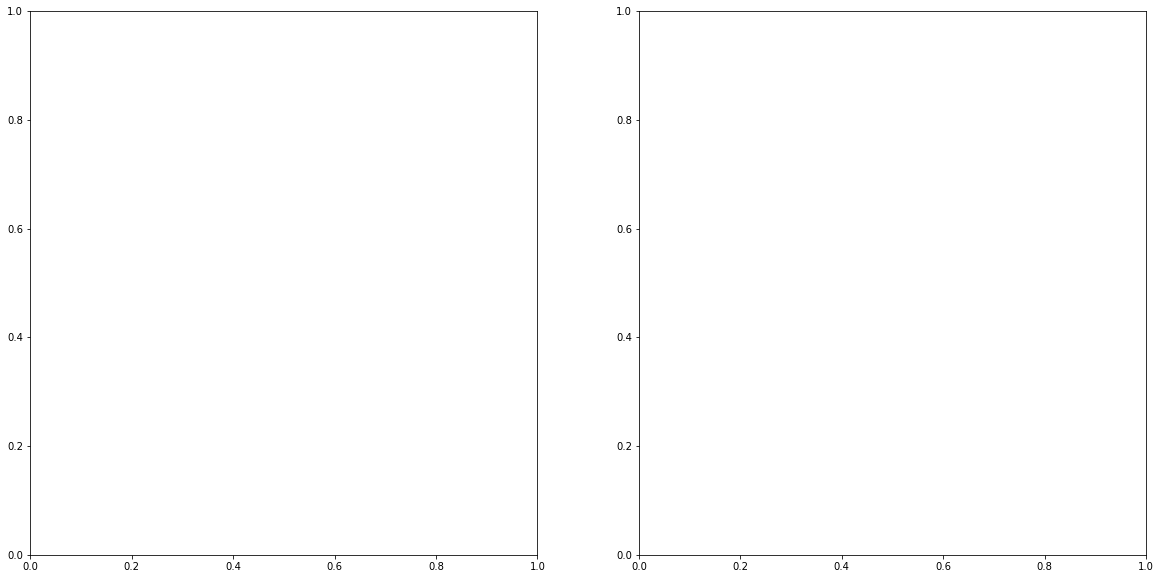

In [68]:
t_str = time()
display.clear_output(wait=False)
f, axarr = plt.subplots(1, 2, figsize=(20,10))
for i in range(500):
    params = next(batch)
    params0 = next(batch0)
    
    feed_dict={ngm.model0.dropout: .0,
               ngm.model0.source_sequence_lengths: params0.source_sequence_lengths,
               ngm.model0.target_sequence_lengths: params0.target_sequence_lengths,
               ngm.model0.encoder_inputs: params0.sources,
               ngm.model0.targets: params0.targets,
               
               ngm.model_u1.learning_rate: .03125,
               ngm.model_u1.max_gradient_norm: 5,
               ngm.weights_ll: params.weights_ll,
               ngm.weights_lu: params.weights_lu,
               ngm.weights_uu: params.weights_uu,
               ngm.cu_ll: params.cu1,
               ngm.cv_ll: params.cv1,
               ngm.cu_lu: params.cu2,
               
               ngm.model_u1.dropout: .0,
               ngm.model_v1.dropout: .0,
               ngm.model_u2.dropout: .0,
               ngm.model_v2.dropout: .0,
               ngm.model_u3.dropout: .0,
               ngm.model_v3.dropout: .0,
               
               ngm.model_u1.source_sequence_lengths: params.len_in_u1,
               ngm.model_u1.target_sequence_lengths: params.len_out_u1,
               ngm.model_u1.encoder_inputs: params.in_u1,
               ngm.model_u1.targets: params.out_u1,
               
               ngm.model_v1.source_sequence_lengths: params.len_in_v1,
               ngm.model_v1.target_sequence_lengths: params.len_out_v1,
               ngm.model_v1.encoder_inputs: params.in_v1,
               ngm.model_v1.targets: params.out_v1,
               
               ngm.model_u2.source_sequence_lengths: params.len_in_u2,
               ngm.model_u2.target_sequence_lengths: params.len_out_u2,
               ngm.model_u2.encoder_inputs: params.in_u2,
               ngm.model_u2.targets: params.out_u2,
               
               ngm.model_v2.source_sequence_lengths: params.len_in_v2,
               ngm.model_v2.target_sequence_lengths: np.ones(params.in_v2.shape[1], 'float32') * EOS_token,
               ngm.model_v2.encoder_inputs: params.in_v2,
               ngm.model_v2.targets: np.ones((max_time, params.in_v2.shape[1]), 'int32') * EOS_token,

               ngm.model_u3.source_sequence_lengths: params.len_in_u3,
               ngm.model_u3.target_sequence_lengths: np.ones(params.in_u3.shape[1], 'float32') * EOS_token,
               ngm.model_u3.encoder_inputs: params.in_u3,
               ngm.model_u3.targets: np.ones((max_time, params.in_u3.shape[1]), 'int32') * EOS_token,
               
               ngm.model_v3.source_sequence_lengths: params.len_in_v3,
               ngm.model_v3.target_sequence_lengths: np.ones(params.in_v3.shape[1], 'float32') * EOS_token,
               ngm.model_v3.encoder_inputs: params.in_v3,
               ngm.model_v3.targets: np.ones((max_time, params.in_v3.shape[1]), 'int32') * EOS_token
               }


    _, l_v, l_d = sess.run([ngm.update_step, ngm.l_vanilla, ngm.l_dist], feed_dict=feed_dict)
    ls_vanilla.append(l_v)
    ls_dist.append(l_d)
    """
    if (i % 10 == 0):
        view_str_idx = 0
        axarr[0].set_color_cycle(['blue', 'orange'])
        axarr[0].plot(np.arange(len(ls_vanilla)-view_str_idx)+view_str_idx, ls_vanilla[view_str_idx:], np.arange(len(ls_dist)-view_str_idx)+view_str_idx, np.array(ls_dist[view_str_idx:]))
        #axarr[0].set_ylim(0,50)
        display.display(f)
        display.clear_output(wait=True)
    """
    if (i % 100 == 0):
        batch_val = batch_iter(128, sources_val, targets_val, ending=True)
        tmp_vals = []
        for params in batch_val:
            feed_dict_test={model.dropout: 0.,
                            model.source_sequence_lengths: params.source_sequence_lengths,
                            model.target_sequence_lengths: params.target_sequence_lengths,
                            model.encoder_inputs: params.sources,
                            model.targets: params.targets}
            tmp_vals.append(sess.run(model.loss_eval, feed_dict_test))
        res.append(np.mean(tmp_vals))
        if res[-1] == np.min(res):
            saver.save(sess, './log/ngm_512_l1_6.ckpt')
        print(res[-1])    
        
        #axarr[1].plot(np.arange(len(res[:])), res[:], color='brown')
        #display.display(f)
        #display.clear_output(wait=True)
            
    print(i, end='\r')

print(time() - t_str)
"""
view_str_idx = 8000
axarr[0].set_color_cycle(['blue', 'orange'])
axarr[0].plot(np.arange(len(ls_vanilla)-view_str_idx)+view_str_idx, ls_vanilla[view_str_idx:], np.arange(len(ls_dist)-view_str_idx)+view_str_idx, np.array(ls_dist[view_str_idx:]))
axarr[0].set_ylim(10,100)
display.display(f)
display.clear_output(wait=True)
axarr[1].plot(np.arange(len(res[70:])), res[70:], color='brown')
display.display(f)
display.clear_output(wait=True)
"""

In [71]:
saver.restore(sess, './log/ngm_512_l1_6_final.ckpt')

INFO:tensorflow:Restoring parameters from ./log/ngm_512_l1_6_final.ckpt


saver.restore(sess, './log/ngm_512_l1_5_final.ckpt')

saver.save(sess, './log/ngm_512_l1_5_final.ckpt')

saver.save(sess, './log/ngm_512_l1_4.ckpt')

saver.save(sess, './log/ngm_512_l1_t.ckpt')

saver.save(sess, './log/ngm_512_l1_s_1.ckpt')

saver.restore(sess, './log/ngm_512_l1_s.ckpt')

saver.restore(sess, './log/ngm_512_l1_f.ckpt')

saver.restore(sess, './log/ngm_512_l1_tmp_s_nodrop.ckpt')

In [75]:
np.mean(ls_vanilla[-100:])

39.287357

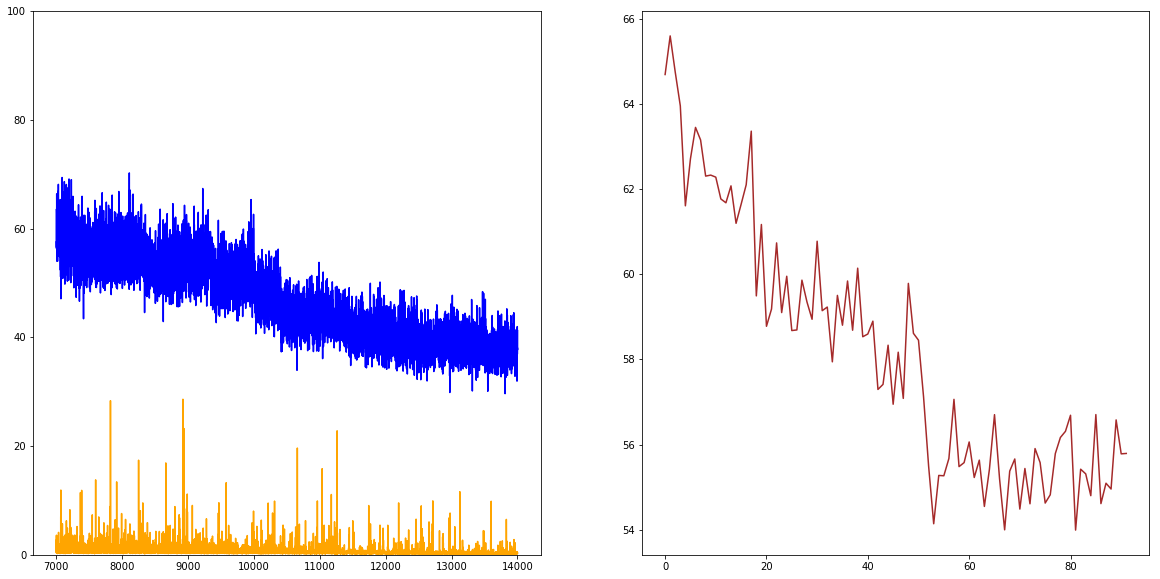

In [80]:
display.clear_output(wait=False)
f, axarr = plt.subplots(1, 2, figsize=(20,10))
view_str_idx = 7000
axarr[0].set_color_cycle(['blue', 'orange'])
axarr[0].plot(np.arange(len(ls_vanilla)-view_str_idx)+view_str_idx, ls_vanilla[view_str_idx:], np.arange(len(ls_dist)-view_str_idx)+view_str_idx, np.array(ls_dist[view_str_idx:]))
axarr[0].set_ylim(0,100)
display.clear_output(wait=True)
axarr[1].plot(np.arange(len(res[50:])), res[50:], color='brown')
display.display(f)
display.clear_output(wait=True)

saver = tf.train.Saver()
saver.save(sess, './log/ngm_512_mahalanobis.ckpt')

ls_file = open('./ngm_512_mahalanobis_ls.txt', 'w')

for i in range(len(ls_vanilla)):
    ls_file.write("%f\t%f\n" % (ls_vanilla[i], ls_dist[i]))

# Test

In [73]:
batch_val = batch_iter(128, sources_val, targets_val, ending=True)
truths = []
preds = []
for params in batch_val:
    feed_dict_test={model.dropout: 0.,
                    model.source_sequence_lengths: params.source_sequence_lengths,
                    model.target_sequence_lengths: params.target_sequence_lengths,
                    model.encoder_inputs: params.sources,
                    model.targets: params.targets}
    
    truths.extend(arr2stn(tgt_vocab, params.targets.T))
    preds.extend(arr2stn(tgt_vocab, np.argmax(sess.run(model.logits_eval, feed_dict_test),2)))
    
_bleu_online([truths], preds)

24.596344480792393

In [107]:
18.81, 21.23, 21.88 21.90 22.28 22.63 22.67 22.72 22.97 23.11 23.51

(18.81, 21.23, 21.88)

In [46]:
with open('./nmt_data/tst2013.en', 'r') as f:
    sources_tst = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
sources_tst = np.array(sources_tst)

with open('./nmt_data/tst2013.vi', 'r') as f:
    targets_tst = [[word2idx(tgt_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
targets_tst = np.array(targets_tst)

In [72]:
batch_val = batch_iter(128, sources_tst, targets_tst, ending=True)
truths = []
preds = []
for params in batch_val:
    feed_dict_test={model.dropout: 0.,
                    model.source_sequence_lengths: params.source_sequence_lengths,
                    model.target_sequence_lengths: params.target_sequence_lengths,
                    model.encoder_inputs: params.sources,
                    model.targets: params.targets}
    
    truths.extend(arr2stn(tgt_vocab, params.targets.T))
    preds.extend(arr2stn(tgt_vocab, np.argmax(sess.run(model.logits_eval, feed_dict_test),2)))
    
_bleu_online([truths], preds)

27.716393120572658

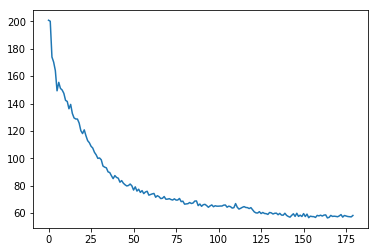

In [43]:
plt.plot(res)

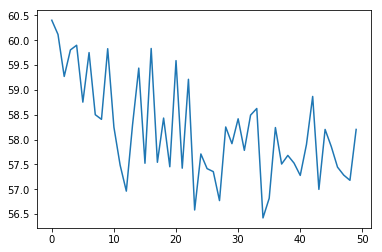

In [47]:
plt.plot(res[-50:])